# Set the file paths
In the cell with TSV_FILE_PATH set the path to tsv file and the path to the files corresponding to the correct experiment number. Only the prefix is required and not the full file names. Afterwards run the cell to set the variables (Press play button while selected).

**NOTE:** the paths should either be absolute paths (c:/Users/enzomo/Downloads/enzo_data/...) or from the current directory. Execute the cell below to see the current directory (can use this to creat absolute paths if needed). Alternatively, on windows can right-click on file and select "copy as path"

In [118]:
import os

os.getcwd()

'/Users/patbu/Desktop/ecms_np_analysis/notebooks'

In [119]:
# FILL in path to tsv file
TSV_FILE_PATH="/Users/patbu/Desktop/ecms_np_analysis/example/20240905_VSP_Au_4nm_2_5min_1M_KHCO3/2024-09-10 16_49_03 Full Test/2024-09-10 16_49_03 Full Test.tsv"

# FILL in path to experiment number files
EXPT_NUM_FILE_PATH="/Users/patbu/Desktop/ecms_np_analysis/example/20240905_VSP_Au_4nm_2_5min_1M_KHCO3/03__02_CP"

In [ ]:
mass_to_species = {
    "M2": "H2",
    "M4": "He",
    "M15": "CH4",
    "M18": "H2O",
    "M26": "C2H4",
    "M28": "CO/N2",
    "M32": "O2",
    "M40": "Ar",
    "M44": "CO2",
}
TSV_FILENAME = os.path.basename(TSV_FILE_PATH)[:-4]
TSV_FILE_DIR = os.path.dirname(TSV_FILE_PATH)

In [120]:
from ixdat import Measurement


ms = Measurement.read(
    TSV_FILE_PATH,
    reader="zilien",
    technique="MS",
)

# ms.plot()

ec = Measurement.read_set(
    EXPT_NUM_FILE_PATH,
    suffix=".mpt",
)

ecms = ec + ms
# ecms["raw_potential"]._data = ecms["<Ewe/V>"]._data # fix for raw_potential being always 0 (not read correctly) 
ecms["raw_potential"]._data = ecms["<Ewe/V>"]._data


In [121]:
# reset the time origin to zero if needed
ecms.t[0]
ecms.tstamp += ecms.t[0] - 1

# Plot ecms
can save/copy plot by hovering over it 

Text(0.5, 0.98, '2024-09-10 16_49_03 Full Test')

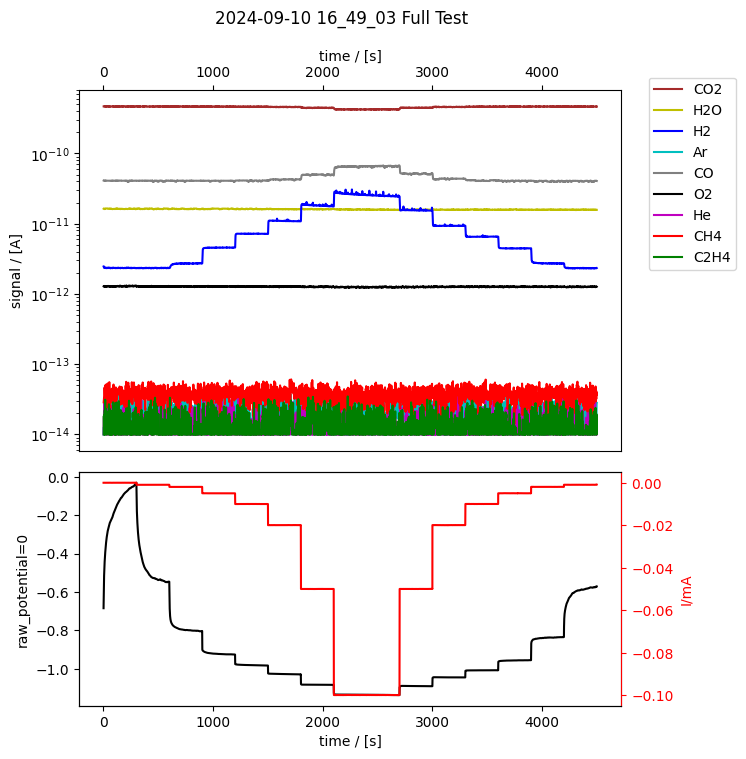

In [133]:


axes = ecms.plot()
fig = axes[0].get_figure()
fig.set_size_inches(
    7, # figure width
    8, # figure height
    # forward=True
)

handles, labels = axes[0].get_legend_handles_labels()
new_labels = [ mass_to_species[x] for x in labels]
new_labels

axes[0].legend(
    loc=(1.05, 0.5), # uncomment to change legend position
    labels=new_labels,
)



fig.suptitle(TSV_FILENAME)

['CO2', 'H2O', 'H2', 'Ar', 'CO', 'O2', 'He', 'CH4', 'C2H4']

Alternatively uncomment the following to save in same folder as tsv file

In [83]:
# fig.savefig(os.path.join(TSV_FILE_DIR, "ecms_plot.png"), dpi=300, bbox_inches='tight',)

# FILL IN: Parameters for Calculating Faradaic Efficiency
set the parameters required for processing the data below. Importantly require the step length for each applied current and the steps (starting from step 0) to calculate faradaic efficiency of CO2RR. Also, provide either the calibration factor and MS background current for H2 reduction (HER) or else the steps/times that should be used to calculate it. Optionally provide the start time (if not 0) and the time prior to end of step to average over for calculations.

In [32]:
STEP_TIME = 300 # seconds

# for calculating the calibration factor from MS current to raw/cell current
# fill in one of the following
HER_ONLY_STEPS = [3, 4, 5,] # step numbers in sequence/program, first step is 1
HER_CALIBRATION_FACTOR = None

# fill in one of the following
HER_BACKGROUND_TIME_INTERVAL = [5100, 5200] # for calculating the background current of the ms
HER_BACKGROUND_CURRENT = None

TIME_AMOUNT_AVERAGE_OVER = 100 # seconds
START_TIME = 0 # if want to start steps from a time other that t=0


# parameter check
assert HER_ONLY_STEPS or HER_CALIBRATION_FACTOR is not None, "must provide HER calibration factor OR the step numbers for calculating it"
assert HER_BACKGROUND_TIME_INTERVAL or HER_BACKGROUND_CURRENT is not None, "must provide H2 MS background current OR time interval to calculate it"

### Optional: Add electrode details

In [33]:
# ecms["raw_potential"]._data = meas["<Ewe/V>"]._data
ecms.calibrate( # do this first
    RE_vs_RHE=0, # if use RHE reference electrode assume that the potential difference between our reference electrode and the RHE potential is zero.
    A_el=0.196, # We know the geometric area of the electrode, so we can normalize the current: it’s a 5mm diameter disk, area = 0.196 cm^2
    R_Ohm=0, # We did not determine the Ohmic drop, but we will assume that it was 0 
)

### Calculate HER background current if required

In [34]:
if HER_BACKGROUND_CURRENT is None:
    times, currents = ecms.grab(item="M2 [A]", tspan=HER_BACKGROUND_TIME_INTERVAL)
    # M2_ave_current = M2_current.mean()
    HER_BACKGROUND_CURRENT = currents.mean()

print("HER MS background current:", HER_BACKGROUND_CURRENT)

HER MS background current: 2.3186923225806456e-12


### Calculate HER calibration factor if required using HER only steps

/opt/anaconda3/envs/ecms/lib/python3.12/site-packages/ixdat/techniques/ms.py:334: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(S - S_bg, t)
/opt/anaconda3/envs/ecms/lib/python3.12/site-packages/ixdat/measurements.py:928: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(v, t)


MSCalResult(name=H2@M2, mol=H2, mass=M2, F=0.10608444263929312)


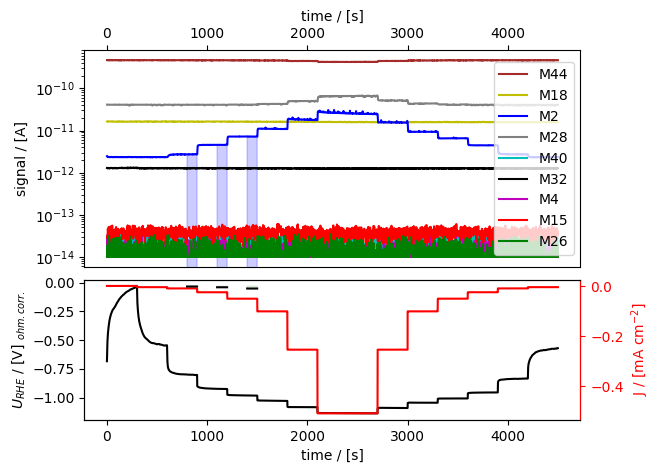

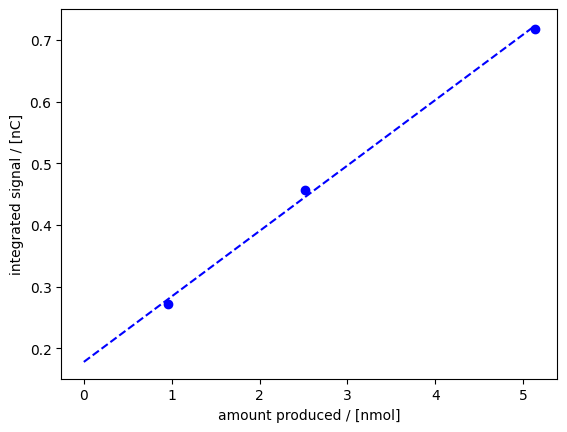

In [35]:
if HER_CALIBRATION_FACTOR is None:
    
    axes = ecms.plot()
    cal_result_H2, ax_b2 = ecms.ecms_calibration_curve(
        mol="H2",
        mass="M2",
        n_el=-2, # remember to use the correct sign: minus for reduction reactions, plus for oxidation reactions
        tspan_list=[
            (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
            for x in HER_ONLY_STEPS
        ],
        ax="new",
        axes_measurement=axes, # to highlight the integrated areas on the plot defined above
        return_ax = True # if True, returns the calibration curve axis as a second element
    )
    print(cal_result_H2) 
    HER_CALIBRATION_FACTOR=cal_result_H2.F # The attribute cal_result_H2.F is the slope of the calibration curve, which is the sensitivity factor in C/mol. 



## Fit conversion between MS current and Cell current using HER only steps

y=mx+b fit coefs: -1815330155.6724026 -0.0009894458484527831


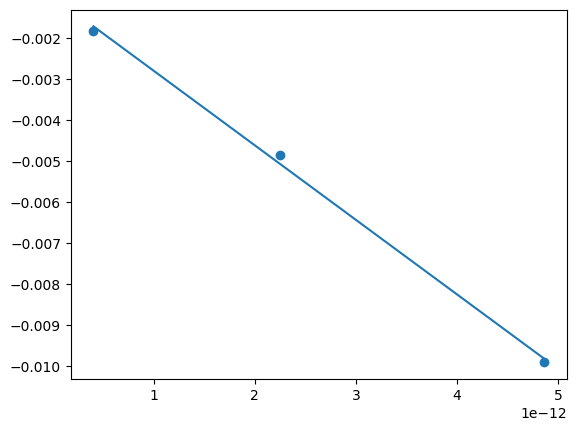

In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

HER_calibration_intervals = [
    (START_TIME + STEP_TIME*(x)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x))
    for x in HER_ONLY_STEPS
]

raw_currents, HER_MS_currents = [], []

for interval in HER_calibration_intervals:
    raw_currents.append(
        ecms.grab(item="raw_current", tspan=interval)[1].mean(),
    )
    HER_MS_currents.append(
        ecms.grab(item="M2 [A]", tspan=interval)[1].mean(),
    )

raw_currents = np.array(raw_currents)
HER_MS_currents = np.array(HER_MS_currents) - HER_BACKGROUND_CURRENT

plt.scatter(
    HER_MS_currents,
    raw_currents,
)

m, b = np.polyfit(
    HER_MS_currents,
    raw_currents,
    1
)

plt.plot(
    HER_MS_currents,
    [m*v+b for v in HER_MS_currents]
)

print("y=mx+b fit coefs:", m, b)

# Calculate CO2RR Faradaic Efficiencies

In [116]:
FE_data = []

all_intervals = [
    (START_TIME + STEP_TIME*(x+1)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x+1))
    for x in range(ecms.selector._data[-1] + 1)
]

for interval in all_intervals:
    raw_current = ecms.grab(item="raw_current", tspan=interval)[1].mean()
    HER_MS_current = ecms.grab(item="M2 [A]", tspan=interval)[1].mean() - HER_BACKGROUND_CURRENT

    HER_cell_current = HER_MS_current * m + b
    CO2RR_cell_current = raw_current - HER_cell_current

    # don't calculate Faradaic efficiency if current is close to background
    if (
        HER_MS_current < HER_BACKGROUND_CURRENT or
        np.isclose(HER_MS_current, HER_BACKGROUND_CURRENT, rtol=0.10, atol=1e-14)
    ):
        CO2RR_cell_current = 0.00
        faradaic_efficiency = 0.0
    else:
        faradaic_efficiency = (CO2RR_cell_current / raw_current) * 100

    FE_data.append([
        interval[0], interval[1],
        HER_MS_current,
        raw_current,
        HER_cell_current,
        CO2RR_cell_current,
        faradaic_efficiency
    ])

FE_data = pd.DataFrame(
    FE_data,
    columns=[
        "start (s)", "end (s)",
        "total cell current (A)",
        "HER MS current (A)",
        "HER cell current (A)",
        "CO2RR cell current (A)",
        "Faradaic Efficiency (%)"]
)

In [117]:
FE_data

,start (s),end (s),total cell current (A),HER MS current (A),HER cell current (A),CO2RR cell current (A),Faradaic Efficiency (%)
0,200,300,2.314695e-14,0.000096,-0.001031,0.000000,0.000000
1,500,600,2.198269e-14,-0.000863,-0.001029,0.000000,0.000000
2,800,900,4.041376e-13,-0.001846,-0.001723,0.000000,0.000000
3,1100,1200,2.249989e-12,-0.004865,-0.005074,0.000000,0.000000
4,1400,1500,4.863420e-12,-0.009905,-0.009818,-0.000087,0.874375
5,1700,1800,8.539778e-12,-0.019835,-0.016492,-0.003343,16.853571
6,2000,2100,1.558476e-11,-0.049882,-0.029281,-0.020601,41.299712
7,2300,2400,2.364507e-11,-0.099796,-0.043913,-0.055883,55.997377
8,2600,2700,2.236746e-11,-0.099806,-0.041594,-0.058212,58.325220
9,2900,3000,1.314084e-11,-0.049880,-0.024844,-0.025035,50.191308


uncomment following line to save csv file in same folder as tsv file

In [89]:
# FE_data.to_csv(os.path.join(TSV_FILE_DIR, "CO2RR_faradaic_efficiencies.csv"), index=False)

### MS currents csv file

In [134]:
mass_list = sorted(ecms.mass_list, key=lambda x: float(x[1:]))

all_intervals = [
    (START_TIME + STEP_TIME*(x+1)-TIME_AMOUNT_AVERAGE_OVER, START_TIME + STEP_TIME*(x+1))
    for x in range(ecms.selector._data[-1] + 1)
]


all_currents = []
for i, interval in enumerate(all_intervals):
    interval_currents = [i, *interval]
    for mass in mass_list:
        interval_currents.append(ecms.grab(f"{mass} [A]", tspan=interval)[1].mean())

    all_currents.append(interval_currents)


all_currents

column_names = ["step num", "start time", "end time",] + [f"{mass_to_species[x]} ave MS current [A]" for x in mass_list]

ms_currents_data = pd.DataFrame(all_currents, columns=column_names)

In [135]:
ms_currents_data

,step num,start time,end time,H2 ave MS current [A],He ave MS current [A],CH4 ave MS current [A],H2O ave MS current [A],C2H4 ave MS current [A],CO ave MS current [A],O2 ave MS current [A],Ar ave MS current [A],CO2 ave MS current [A]
0,0,200,300,2.341839e-12,1.143727e-14,3.931096e-14,1.627497e-11,1.129020e-14,4.072505e-11,1.295079e-12,2.049324e-14,4.662374e-10
1,1,500,600,2.340675e-12,9.236038e-15,3.755622e-14,1.629657e-11,8.458893e-15,4.054483e-11,1.279302e-12,2.133949e-14,4.664168e-10
2,2,800,900,2.722830e-12,1.144842e-14,3.840016e-14,1.624268e-11,8.194091e-15,4.083605e-11,1.274792e-12,2.098174e-14,4.657090e-10
3,3,1100,1200,4.568681e-12,1.476454e-14,3.976740e-14,1.629213e-11,1.014327e-14,4.069045e-11,1.278524e-12,2.271927e-14,4.648107e-10
4,4,1400,1500,7.182113e-12,9.772473e-15,3.834478e-14,1.614673e-11,1.062130e-14,4.090172e-11,1.273004e-12,1.851850e-14,4.627898e-10
5,5,1700,1800,1.085847e-11,1.118963e-14,3.996328e-14,1.609170e-11,1.282258e-14,4.259707e-11,1.274021e-12,2.234425e-14,4.585998e-10
6,6,2000,2100,1.790345e-11,6.951577e-15,3.714004e-14,1.608255e-11,1.356588e-14,4.962337e-11,1.261192e-12,1.802460e-14,4.459972e-10
7,7,2300,2400,2.596377e-11,5.761924e-15,3.734926e-14,1.590049e-11,1.176523e-14,6.510300e-11,1.248682e-12,2.231398e-14,4.235021e-10
8,8,2600,2700,2.468615e-11,6.934368e-15,3.600098e-14,1.576457e-11,8.535042e-15,6.580740e-11,1.250726e-12,2.267617e-14,4.243010e-10
9,9,2900,3000,1.545953e-11,1.075923e-14,3.726959e-14,1.577867e-11,1.347100e-14,5.135208e-11,1.258673e-12,2.128880e-14,4.470925e-10


uncomment the following to save data in same folder as tsv file

In [84]:
# ms_currents_data.to_csv(os.path.join(TSV_FILE_DIR, "all_ms_currents.csv"), index=False)